In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import osmnx as ox
from shapely.geometry import LineString
import geopandas as gpd
from shapely import Polygon
from rasterio.transform import from_origin
from rasterio import features


poland_crs = 2180

def get_all_highways(graph):
    highways = []
    for u, v, k, data in graph.edges(keys=True, data=True):
        if "highway" in data and data["highway"] not in highways and not isinstance(data["highway"], list):
            highways.append(data["highway"])
        elif isinstance(data["highway"], list):
            highways.extend(h for h in data["highway"] if h not in highways)

    return highways

def get_avg_width(graph, highway):
    count_street = 0
    sum_width = 0

    for u, v, data in list(graph.edges(data=True)):
        width = 0
        if "highway" in data and ((not isinstance(data["highway"], list) and data["highway"] == highway) or (isinstance(data["highway"], list) and highway in data["highway"])):
            if "width" in data:
                if isinstance(data["width"], list):
                    width = np.mean([float(x) for x in data["width"]])         
                else:
                    width = float(data["width"])
            elif 'lanes' in data:
                if isinstance(data["lanes"], list):
                    width = np.mean([int(x) for x in data["lanes"]]) * 3
                else:
                    width = int(data['lanes']) * 3  # przyjmujemy 3 m na pas
            sum_width += width
            count_street += 1
            
    return sum_width/count_street

def get_highways_width(graph):
    highways = get_all_highways(graph)
    avg_width = {}

    for highway in highways:
        avg_width[highway] = get_avg_width(graph, highway)
    
    return avg_width

In [2]:
import osmnx as ox
from shapely.geometry import LineString


def get_edges_measurements(graph):

    # mapping szerokości w zależności od typu drogi
    highway_width = get_highways_width(graph)

    # Lista wyników
    edges_info = []
    lanes_width_counter = 0
    highway_width_counter = 0
    for u, v, k, data in graph.edges(keys=True, data=True):
        # Długość odcinka
        if 'length' in data:
            length = data['length']  # w metrach
        elif 'geometry' in data:
            # jeśli geometry to LineString, liczymy długość
            if isinstance(data['geometry'], LineString):
                # Używamy funkcji OSMnx do obliczenia długości geograficznej w metrach
                length = ox.distance.great_circle_vec(
                    *data['geometry'].coords[0][::-1],  # lat, lon pierwszego punktu
                    *data['geometry'].coords[-1][::-1]  # lat, lon ostatniego punktu
                )
            else:
                length = 0
        else:
            length = 0

        # Szerokość odcinka
        if 'width' in data:
            lanes_width_counter += 1
            if isinstance(data["width"], list):
                width = np.mean([float(x) for x in data["width"]])         
            else:
                width = float(data["width"])
                    
        elif 'lanes' in data:
            lanes_width_counter += 1
            if isinstance(data["lanes"], list):
                width = np.mean([int(x) for x in data["lanes"]]) * 3
            else:
                width = int(data['lanes']) * 3  # przyjmujemy 3 m na pas
        elif 'highway' in data:
            highway_width_counter += 1
            hw = data['highway']
            if isinstance(hw, list):
                hw = hw[0]
            width = highway_width.get(hw)
        else:
            width = 6

        if "geometry" in data:
            edges_info.append({"id": data["osmid"],'u': u, 'v': v, 'length_m': length, 'width_m': width, "geometry" : data["geometry"]})
    print(f"Liczba ulic z szerokością: {lanes_width_counter}\nLiczba ulic bez szerokości: {highway_width_counter}")

    return edges_info


In [3]:
def get_straight_line_coefficients(x1, y1, x2, y2):
    if x1 == x2 and y1 == y2:
        raise ValueError("Punkty są identyczne — nie można wyznaczyć prostej.")

    a = y1 - y2
    b = x2 - x1
    c = x1 * y2 - x2 * y1

    return (a, b, c)


def get_perpendicular_line(a, b):
    if a == 0 and b == 0:
        raise ValueError("Nieprawidłowe współczynniki — to nie jest równanie prostej.")

    a_p = b
    b_p = -a
    return (a_p, b_p)


def segment_from_line(A, B, x_s, y_s, width):
    vx, vy = B, -A

    # Normalizacja do długości 1
    norm = np.sqrt(A**2 + B**2)
    vx /= norm
    vy /= norm

    d = width / 2

    # Końce odcinka
    x1 = x_s + vx * d
    y1 = y_s + vy * d
    x2 = x_s - vx * d
    y2 = y_s - vy * d

    return (x1, y1), (x2, y2)

In [4]:
def get_edge_polygon(edge):
    xs, ys = edge.geometry.xy
    xs = list(xs)
    ys = list(ys)
    right_side = []
    left_side = []
    
    if len(xs) == len(ys):
        for i in range(len(xs) - 1):
            x1 = xs[i]
            y1 = ys[i]
            x2 = xs[i + 1]
            y2 = ys[i + 1]
            coef = get_straight_line_coefficients(x1, y1, x2, y2)
            perpendicular_coef = get_perpendicular_line(coef[0], coef[1])
            (new_left_x1, new_left_y1), (new_right_x1, new_right_y1) = segment_from_line(perpendicular_coef[0], perpendicular_coef[1], x1, y1, edge.width_m)
            (new_left_x2, new_left_y2), (new_right_x2, new_right_y2)  = segment_from_line(perpendicular_coef[0], perpendicular_coef[1], x2, y2, edge.width_m)
            left_side.append((new_left_x1, new_left_y1))
            right_side.append((new_right_x1, new_right_y1))
            left_side.append((new_left_x2, new_left_y2))
            right_side.append((new_right_x2, new_right_y2))
    coords = left_side + right_side[::-1]
    coords.append(left_side[0])
    polygon = Polygon(coords)
    return polygon

In [5]:
def get_rasterize_roads(gdf_edges, pixel_size = 1):
    min_x, min_y, max_x, max_y = gdf_edges.total_bounds
    width_m = int(max_x - min_x)
    height_m = int(max_y - min_y)

    print(height_m, width_m)
    transform = from_origin(int(min_x), int(max_y), pixel_size, pixel_size)

    grid = features.rasterize(
        [(geometry, 1) for geometry in gdf_edges.geometry],
        out_shape=(height_m, width_m), 
        transform=transform,
        fill=0,
        all_touched=True,
        dtype=np.uint8
    )
    print(np.sum(grid)/(grid.shape[0] * grid.shape[1]))

    return grid

In [23]:
def get_city_grid(city):
    graph = ox.graph.graph_from_place(city, network_type="drive")

    edges = get_edges_measurements(graph)

    gdf_edges = gpd.GeoDataFrame(edges, crs="EPSG:4326")
    gdf_edges["geometry"] = gdf_edges["geometry"].to_crs(epsg=poland_crs)

    gdf_edges["geometry"] = gdf_edges.apply(lambda row: get_edge_polygon(row), axis=1)

    grid = get_rasterize_roads(gdf_edges)

    return grid

In [24]:
grid = get_city_grid("Kraków, Poland")

Liczba ulic z szerokością: 8499
Liczba ulic bez szerokości: 12842
16638 29494
0.018554685470143113


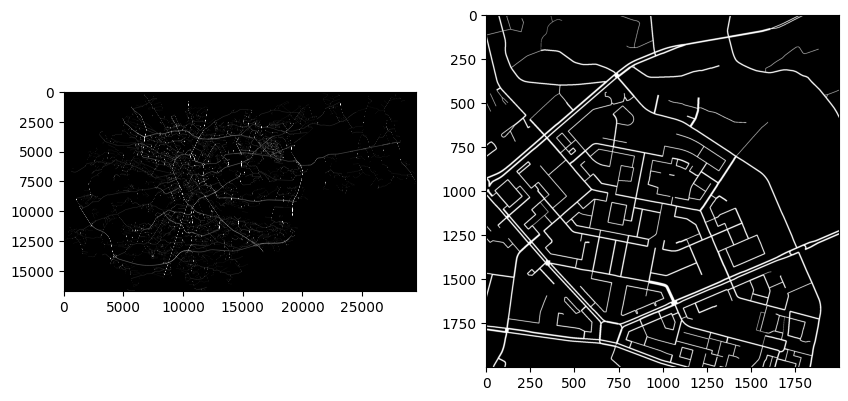

In [22]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 8)
axes[0].imshow(grid, cmap="gray")
axes[1].imshow(grid[3500 : 5500, 16500 : 18500], cmap="gray")

In [8]:
import pickle

with open("../grids/Słupsk.pkl", "wb") as file:
    pickle.dump(grid, file)


FileNotFoundError: [Errno 2] No such file or directory: '../grids/Słupsk.pkl'